In [1]:
"""
Author: Zaw
Learning Curve using MLP
"""

import numpy as np
import pandas as pd
import math
import time
import os
import seaborn
import warnings
warnings.simplefilter(action='ignore')
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn import preprocessing
import pickle
start = time.time()

In [2]:
# Rescale the feature
def scale(col):
    return (col - np.min(col))/(np.max(col)-np.min(col))
    #return (col - np.mean(col))/np.std(col)

# Import descriptor file
path = os.getcwd()
dirname = os.path.dirname(path)
data_path = dirname+"/logD/data/descriptors.csv"
des_df = pd.read_csv(data_path,index_col=0)

## LC informations
# Import LC informations
path = os.getcwd()
data_path = path+"/data/df_2000.csv"
col_list=['LogD','Exp_RT']
lc_df = pd.read_csv(data_path,usecols=col_list)

In [3]:
des_with_lc = pd.concat([des_df,lc_df],axis=1)
des_with_lc_feat_corr = des_with_lc.columns[des_with_lc.corrwith(des_with_lc['LogD']) >=0.90][:-1]
des_with_lc = des_with_lc.drop(columns=des_with_lc_feat_corr)

# Filling the nan with mean values in des_with_lc
for col in des_with_lc:
    des_with_lc[col].fillna(des_with_lc[col].mean(),inplace=True)

# Remove columns with zero vlues
des_with_lc = des_with_lc.loc[:,(des_with_lc**2).sum() != 0]
data = des_with_lc.drop(['LogD'],axis=1)

# Remove features with low Variance(threshold<=0.05)
data_var = data.var()
del_feat = list(data_var[data_var <= 0.05].index)
data.drop(columns=del_feat, inplace=True)

# Remove features with correlation(threshold > 0.95)
corr_matrix = data.corr().abs()
mask = np.triu(np.ones_like(corr_matrix,dtype=bool))
tri_df = corr_matrix.mask(mask)
to_drop =  [ c for c in tri_df.columns if any(tri_df[c] > 0.95)]
data = data.drop(to_drop,axis=1)

# Scale the features
cols = list(data)
data[cols] = data[cols].apply(scale,axis=0)
data = pd.concat([data,des_with_lc['LogD']],axis=1)

train , rest = train_test_split(data,train_size = 0.8,shuffle=True,random_state = 1)
validate , test = train_test_split(rest, train_size = 0.5, shuffle=True,random_state = 1)

# training set
data_tra_x = train.drop(['LogD'],axis=1)
data_tra_y = train['LogD']

# validation set
data_val_x = validate.drop(['LogD'],axis=1)
data_val_y = validate['LogD']

# test set
data_tes_x = test.drop(['LogD'],axis=1)
data_tes_y = test['LogD']

# The dataset without lc informations
#load the model without lc
path = os.getcwd()
dirname = os.path.dirname(path)
file_path = dirname+"/logd/hyperparameters/mlp_lc.pkl"
best_parameters_with_lc = pickle.load(open(file_path,'rb'))

# parameters
hidden_layer_sizes_list = [(150,100,50), (120,80,40) ,(100,50,30)]
max_iter_list =[5,10,50,100,200]
activation_list = ['relu', 'tanh', 'logistic']
solver_list = ['sgd','adam']
alpha_list = [0.0001, 0.05]
learning_rate_list =['constant','adaptive']

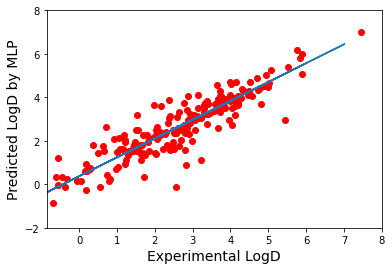

In [4]:
best_model = MLPRegressor(hidden_layer_sizes = hidden_layer_sizes_list[best_parameters_with_lc['hidden_layer_sizes']],
                            max_iter = max_iter_list[best_parameters_with_lc['max_iter']],
                            activation = activation_list[best_parameters_with_lc['activation']],
                            solver = solver_list[best_parameters_with_lc['solver']],
                            alpha = alpha_list[best_parameters_with_lc['alpha']],
                            learning_rate = learning_rate_list[best_parameters_with_lc['learning_rate']]
                            )
best_model.fit(data_tra_x,data_tra_y)
tes_pred = best_model.predict(data_tes_x)
plt.xlim([-0.85,8])
plt.ylim([-2,8])
plt.scatter(data_tes_y,tes_pred,c='r',alpha=1)
a,b = np.polyfit(data_tes_y,tes_pred, 1)
plt.plot(tes_pred, a*tes_pred+b)
plt.xlabel('Experimental LogD',fontsize = 14)
plt.ylabel('Predicted LogD by MLP',fontsize = 14)

plt.savefig(dirname+"/logD/results/logd_mlp_vs.png", format='png', dpi=600)# plt.savefig("svm.png", format='png', dpi=600)
plt.show()

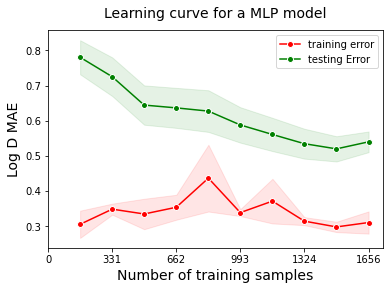

In [5]:
X = data.drop(['LogD'],axis=1)
y = data['LogD']

train_sizes=np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, validation_scores = learning_curve(estimator =  MLPRegressor(hidden_layer_sizes = hidden_layer_sizes_list[best_parameters_with_lc['hidden_layer_sizes']],
                            max_iter = max_iter_list[best_parameters_with_lc['max_iter']],
                            activation = activation_list[best_parameters_with_lc['activation']],
                            solver = solver_list[best_parameters_with_lc['solver']],
                            alpha = alpha_list[best_parameters_with_lc['alpha']],
                            learning_rate = learning_rate_list[best_parameters_with_lc['learning_rate']]
                            ), X = X,y = y, train_sizes = train_sizes,
                            cv = 5,scoring = 'neg_mean_absolute_error')


train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)

validation_scores_mean = -validation_scores.mean(axis = 1)
validation_scores_std = validation_scores.std(axis=1)


fig, ax = plt.subplots()
ax.plot(train_sizes, train_scores_mean,"o-",markeredgecolor='white', label = 'training error',color='r')
ax.fill_between(train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
ax.plot(train_sizes, validation_scores_mean, "o-",markeredgecolor='w', label = 'testing Error',color='g')
ax.fill_between(train_sizes,
        validation_scores_mean - validation_scores_std,
        validation_scores_mean + validation_scores_std,
        alpha=0.1,
        color="g",
    )
ax.set_xticks([0,331,662,993,1324,1656])
ax.set_xticklabels([0,331,662,993,1324,1656])
ax.set_ylabel('Log D MAE', fontsize = 14)
ax.set_xlabel('Number of training samples', fontsize = 14)
ax.set_title('Learning curve for a MLP model', fontsize = 14, y = 1.03)
ax.legend()
plt.savefig(dirname+"/LogD/results/mlp_lc.png", format='png', dpi=600)
plt.show()

In [44]:
import numpy as np
import pandas as pd
import time
import os
import warnings
import pickle
warnings.simplefilter(action='ignore')
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
start = time.time()

# Rescale the feature
def scale(col):
    return (col - np.min(col))/(np.max(col)-np.min(col))

## LC informations
# Import LC informations
path = os.getcwd()
data_path = path+"/data/extract_data.csv"
col_list=['LogP','Exp_RT']
lc_df = pd.read_csv(data_path,usecols=col_list)

# Remove non_retained molecules
index=lc_df[lc_df['Exp_RT'] < 180].index
lc_df.drop(lc_df[lc_df['Exp_RT'] < 180].index,inplace=True)

# Import descriptor file
path = os.getcwd()
data_path = path+"/data/descriptors.csv"

# Read only top descriptor
col_list = ['PEOE_VSA7','VSA_EState6','PEOE_VSA6','EState_VSA8', 'MolMR','BCUT2D_LOGPLOW','SMR_VSA7','NumAromaticRings']
des_df = pd.read_csv(data_path,usecols=col_list)

In [42]:
des_df

,BCUT2D_LOGPLOW,PEOE_VSA6,PEOE_VSA7,SMR_VSA7,EState_VSA8,VSA_EState6,NumAromaticRings,MolMR
0,-2.024331,18.685622,5.752854,0.000000,0.000000,0.000000,0.0,30.0461
1,-2.594557,29.268247,43.627342,33.807819,4.899910,5.239555,1.0,105.3190
2,-1.772464,6.066367,18.199101,30.462312,4.983979,6.599815,2.0,45.0726
3,-2.023014,12.132734,30.661764,29.828920,0.000000,5.582639,1.0,47.4942
4,-2.183736,18.199101,12.132734,42.222607,15.284746,9.809631,3.0,66.9899
...,...,...,...,...,...,...,...,...
2066,-2.016515,23.354814,36.101280,60.049269,21.304740,10.031027,3.0,94.6243
2067,-2.422958,0.000000,32.046576,36.540486,15.066639,3.610664,3.0,116.5678
2068,-2.593965,26.344316,74.190480,11.649125,13.847474,0.000000,0.0,107.9168
2069,-2.272436,18.199101,24.974377,36.025763,4.983979,9.918556,2.0,63.4362


In [45]:
lc_df

,LogP,Exp_RT
1,2.64,687.8
2,1.73,583.6
3,1.05,653.1
4,1.33,705.6
5,1.34,621.0
...,...,...
2066,2.05,603.4
2067,1.59,1061.4
2068,3.73,1059.3
2069,1.70,794.3


In [ ]:
from sklearn.inspection import permutation_importance
r = permutation_importance(best_model,)

data_val_x = validate.drop(['LogD'],axis=1)
data_val_y = validate['LogD']